In [1]:
# requires Python 2 #

In [2]:
# READ DATA OnlineRetail.xlsx

import pandas as pd
dfs = pd.read_excel('C:\Users\kumarsa\Desktop\Sudodesktop\R&C DTS\OnlineRetail.xlsx', sheet_name='OnlineRetail', index = 'InvoiceDate')

In [3]:
# Meta data
#exploring the unique values

print "Total Number of Interactions #", dfs['InvoiceNo'].count()
print "Number of Unique Interactions #", dfs['InvoiceNo'].nunique()
print "Number of Unique products bought #",dfs['StockCode'].nunique()
print "Number of Unique customers #", dfs['CustomerID'].nunique()
print "Percentage of NA customers %", round(dfs['CustomerID'].isnull().sum() * 100 / len(dfs),2)
print 'Number of countries #',dfs['Country'].nunique()

Total Number of Interactions # 541909
Number of Unique Interactions # 25900
Number of Unique products bought # 4070
Number of Unique customers # 4372
Percentage of NA customers % 24.0
Number of countries # 38


In [4]:
# Cancelled invoices
# Few InvoiceNo start with the letter "c" = cancelled.

cancelled_orders = dfs[dfs['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom

In [5]:
#check how many rows our dataframe of cancelled orders contain

total_orders = dfs['InvoiceNo'].nunique()
cancelled_number = len(cancelled_orders)
print 'Number of Canceled Orders #',cancelled_number

Number of Canceled Orders # 9288


In [6]:
#remove canceled orders

dfs = dfs[dfs['Quantity']>0]
dfs.shape

(531285, 8)

In [7]:
#remove rows where customerID is NA

dfs.dropna(subset=['CustomerID'],how='all',inplace=True)
dfs.shape

(397924, 8)

In [8]:
#Add a new column AmountSpend: Multiplying Quantity and UnitPrice columns

dfs['AmountSpend'] = dfs['Quantity']*dfs['UnitPrice']

In [9]:
## Keeping relevant coluns from the Database

matrix_setup = dfs[['StockCode','CustomerID','AmountSpend','InvoiceDate']]
matrix_setup.shape

(397924, 4)

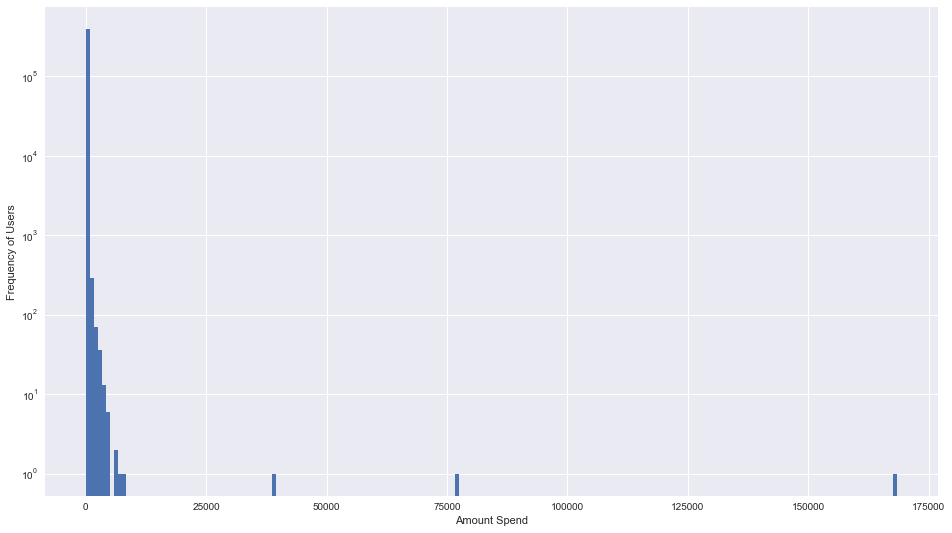

In [10]:
#plotting the amount spend

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]

import seaborn as sns
sns.set()
plt.hist(matrix_setup['AmountSpend'],bins=200, log=True)
plt.xlabel('Amount Spend')
plt.ylabel('Frequency of Users')
plt.show()

In [11]:
# setting all existing transactions as Item_bought i.e. 1

matrix_setup['AmountSpend'].loc[matrix_setup['AmountSpend']  > 0 ] = 1

C:\ProgramData\Anaconda\Anaconda2\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Rename the column AmountSpend as Itembought
matrix_setup = matrix_setup.rename(columns = {'AmountSpend':'ItemBought'})

In [13]:
# the dataframe has only positive value for Itembought
# There is a need to fill in rows where the item was not bought. As model needs to learn both bought or not bought.

In [14]:
# A list of all unique customers
customer_all = [i for i in matrix_setup['CustomerID']]
customer_unique = set(customer_all)
print len(customer_unique)," #unique customers"
print len(customer_all)," #all customers"

4339  #unique customers
397924  #all customers


In [15]:
# A list of all unique items
items_all = [i for i in matrix_setup['StockCode']]
items_unique = set(items_all)
print len(items_unique)," #unique customers"
print len(items_all)," #all customers"

3665  #unique customers
397924  #all customers


In [16]:
# creating user and item tuples
tuple_x = [list(zip(matrix_setup.CustomerID,matrix_setup.StockCode))]

In [17]:
# create negative rows
# rows which depicts that item was not bought
import random
neg_rows = []
for i in customer_unique:
    counter = 0
    shuffled_stock = list(items_unique)
    random.shuffle(shuffled_stock)
    for j in shuffled_stock:
        if counter == 20:
            break
        elif (i,j) not in tuple_x:
            row = (j,i)
            neg_rows.append(row)
            counter = counter + 1

In [18]:
# Intializing a dataframe to be used for negative rows
columns=['StockCode','CustomerID','ItemBought','InvoiceDate']
df3 = pd.DataFrame(columns=columns)

In [19]:
# creating a random time stamp list to be used in next step
Invoice_list = [i for i in matrix_setup['InvoiceDate']] 
random.shuffle(Invoice_list)

In [20]:
#Creating the itembought = 0 transaction dataframe
count = len(matrix_setup['StockCode'])
for i in range(len(neg_rows)):
    row = pd.Series({'StockCode':neg_rows[i][0],'CustomerID':neg_rows[i][1],'ItemBought':0,'InvoiceDate':Invoice_list[i]} )
    df3 = df3.append(row,ignore_index=True)

In [21]:
# Merging the two Dataframe
matrix_setup = matrix_setup.append(df3)

In [22]:
# Top of setup
matrix_setup.head()

StockCode  CustomerID ItemBought         InvoiceDate
0    85123A     17850.0          1 2010-12-01 08:26:00
1     71053     17850.0          1 2010-12-01 08:26:00
2    84406B     17850.0          1 2010-12-01 08:26:00
3    84029G     17850.0          1 2010-12-01 08:26:00
4    84029E     17850.0          1 2010-12-01 08:26:00

In [23]:
# Bottom of setup 
matrix_setup.tail()

StockCode  CustomerID ItemBought         InvoiceDate
86775     37342     16383.0          0 2011-08-03 12:10:00
86776     23039     16383.0          0 2011-10-16 13:08:00
86777     37475     16383.0          0 2011-12-04 12:32:00
86778     22628     16383.0          0 2011-05-12 09:49:00
86779     82551     16383.0          0 2011-03-04 12:37:00

In [24]:
# as we can see that all of the Items_not_bought transactions are appended at the bottonm of the dataframe
# we need to sort the dataframe based on InvoiceDate
# so that we get a good mix of Bought and not bought transactions
# This will be interesting aspect for testing the predictions based on Time Based split
matrix_setup = matrix_setup.sort_values('InvoiceDate')

In [25]:
# Dataframe sorted on the basis of Time-Stamp(InvoiceDate)
matrix_setup[:10]

StockCode  CustomerID ItemBought         InvoiceDate
0        85123A     17850.0          1 2010-12-01 08:26:00
30452    85230G     12528.0          0 2010-12-01 08:26:00
74911     22336     15570.0          0 2010-12-01 08:26:00
6         21730     17850.0          1 2010-12-01 08:26:00
5         22752     17850.0          1 2010-12-01 08:26:00
79548     22183     15881.0          0 2010-12-01 08:26:00
3        84029G     17850.0          1 2010-12-01 08:26:00
2        84406B     17850.0          1 2010-12-01 08:26:00
1         71053     17850.0          1 2010-12-01 08:26:00
4        84029E     17850.0          1 2010-12-01 08:26:00

In [26]:
# Zero has been set to 0.00001. 
# Therefore, the two values seen as Quantity of Interest are 0.00001 and 1
matrix_setup['ItemBought'].loc[matrix_setup['ItemBought']  == 0 ] = 0.00001

In [27]:
lower_bound = min(matrix_setup['ItemBought'])
upper_bound = max(matrix_setup['ItemBought'])
print lower_bound
print upper_bound

1e-05
1.0


In [28]:
# Importing all packages for Latent factor modeling
from surprise import SVD,NMF,SVDpp,evaluate
from surprise.dataset import Dataset
from surprise import Reader

In [29]:
#define the reader  with  upper and lower bounds , also now we are predicting Normalized Total Amount column
reader_x = Reader(rating_scale = (lower_bound,upper_bound))

In [30]:
data = Dataset.load_from_df(df=matrix_setup[['CustomerID','StockCode','ItemBought']],reader=reader_x)

In [31]:
# for 90:10 distribution of the dataset
# find the dataframe index number which marks 90 percent of dataset
mark_90 = (matrix_setup.shape[0]/100)*90
mark_90

436230

In [32]:
# Splitting the dataset based on Timestamp for Traing and Testing
dfx_90 = data.raw_ratings[0:mark_90]
test_10 = data.raw_ratings[mark_90+1:]
print "Toatl records in Training: ",len(dfx_90)
neg_dfx = [i[2]  for i in dfx_90 if i[2] < 1]
print "Total Not_Bought records in Training ",len(neg_dfx)
print "Percentage %",float(len(neg_dfx)*100/len(dfx_90))

Toatl records in Training:  436230
Total Not_Bought records in Training  78023
Percentage % 17.0


In [33]:
print "Toatl records in Testing: ",len(test_10)
neg_test = [i[2]  for i in test_10 if i[2] < 1]
print "Toatl Not_Bought records in Testing: ",len(neg_test)
print "Percentage %",float(len(neg_test)*100/len(test_10))

Toatl records in Testing:  48473
Toatl Not_Bought records in Testing:  8797
Percentage % 18.0


In [34]:
# Choosing the Model: PMF - > SVD with biased = False
# Setting up the Model  using best hyper parameters 
# GridSearch has been performed to get these hyperparameter setting: best RMSE
#param_grid = {'n_factors':[2,5,50],'n_epochs': [5,10,50], 'lr_all': [0.1,0.01,0.001],'reg_all': [0.1,0.01,0.001], 'biased' :[False]}
#grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=1)

algo = SVD(lr_all=0.01, reg_all= 0.001, n_factors=5, n_epochs=50, biased = False)

In [35]:
#creating the trainingset 
trainset = data.construct_trainset(dfx_90)
#creating the testset
testset = data.construct_testset(test_10)

In [36]:
# Train the algorithm on the trainset, and predict ratings for the testset

# check out time
import time
start_time = time.time()
algo.fit(trainset)
print("---%s Time required for Traing the Model in seconds-----" % (time.time() - start_time))



---11.611000061 Time required for Traing the Model in seconds-----


In [37]:
# Predictions
start_time = time.time()

predictions = algo.test(testset)
print("---%s Time required for Prediction in seconds----" % (time.time() - start_time))

---0.269999980927 Time required for Prediction in seconds----


In [38]:
# Then compute RMSE,MAE

from surprise import accuracy
print 'RMSE over test set ', accuracy.rmse(predictions)
print 'MAE over test set ',accuracy.mae(predictions)

RMSE over test set RMSE: 0.4417
 0.4416532963435199
MAE over test set MAE:  0.2757
 0.27572511601746813


In [39]:
# List of Test Amount
test_list = []
for i in testset:
    test_list.append(i[-1])

In [40]:
prediction_list = []
Threshold = 0.5
for i in predictions:
    if i[3] >=  Threshold:
        prediction_list.append(1)
    else:
        prediction_list.append(0)

In [41]:
# Making the True values discrete
y_true = [1 if i == 1 else 0 for i in test_list ]

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,prediction_list)

array([[ 4817,  3980],
       [ 7201, 32475]], dtype=int64)

In [43]:
from sklearn.metrics import precision_score
precision_score(y_true,prediction_list,average=None)

array([0.40081544, 0.8908243 ])

In [44]:
from sklearn.metrics import recall_score
recall_score(y_true,prediction_list,average=None)

array([0.54757304, 0.81850489])

In [45]:
from sklearn.metrics import f1_score
f1_score(y_true,prediction_list,average=None)

array([0.4628393 , 0.85313473])

In [46]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(algo.pu)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
# plotting the users as clusters
plt.scatter(algo.pu[:, 0], algo.pu[:, 1], c=kmeans.labels_)
plt.rcParams["figure.figsize"] = [16,9]

In [48]:
import numpy as np
Users_Y = [y for y in np.where(kmeans.labels_ == 2) ]
Users_X = [x for x in np.where(kmeans.labels_ == 4) ]
counter = []
real_user_x = trainset.to_raw_uid(Users_X[0][0])
set_of_items_real_user = matrix_setup['StockCode'][matrix_setup['CustomerID'] == real_user_x]
set_of_items_real_user = set_of_items_real_user.to_frame()
for i in Users_X[0][1:]:
    neighbor_user_x = trainset.to_raw_uid(i)
    set_of_items_neighbor = matrix_setup['StockCode'][matrix_setup['CustomerID'] == neighbor_user_x]
    set_of_items_neighbor = set_of_items_neighbor.to_frame()
    print (set_of_items_real_user.merge(set_of_items_neighbor)).count()
    counter.append((set_of_items_real_user.merge(set_of_items_neighbor)).count()[0])


    

StockCode    0
dtype: int64
StockCode    11
dtype: int64
StockCode    5
dtype: int64
StockCode    1
dtype: int64
StockCode    13
dtype: int64
StockCode    1
dtype: int64
StockCode    1
dtype: int64
StockCode    8
dtype: int64
StockCode    7
dtype: int64
StockCode    5
dtype: int64
StockCode    1
dtype: int64
StockCode    8
dtype: int64
StockCode    101
dtype: int64
StockCode    77
dtype: int64
StockCode    76
dtype: int64
StockCode    11
dtype: int64
StockCode    7
dtype: int64
StockCode    2
dtype: int64
StockCode    13
dtype: int64
StockCode    4
dtype: int64
StockCode    16
dtype: int64
StockCode    35
dtype: int64
StockCode    53
dtype: int64
StockCode    12
dtype: int64
StockCode    10
dtype: int64
StockCode    25
dtype: int64
StockCode    11
dtype: int64
StockCode    26
dtype: int64
StockCode    13
dtype: int64
StockCode    18
dtype: int64
StockCode    2
dtype: int64
StockCode    2
dtype: int64
StockCode    19
dtype: int64
StockCode    5
dtype: int64
StockCode    45
dtype: int64


StockCode    25
dtype: int64
StockCode    9
dtype: int64
StockCode    38
dtype: int64
StockCode    4
dtype: int64
StockCode    31
dtype: int64
StockCode    19
dtype: int64
StockCode    0
dtype: int64
StockCode    15
dtype: int64
StockCode    11
dtype: int64
StockCode    40
dtype: int64
StockCode    9
dtype: int64
StockCode    86
dtype: int64
StockCode    2
dtype: int64
StockCode    35
dtype: int64
StockCode    33
dtype: int64
StockCode    12
dtype: int64
StockCode    5
dtype: int64
StockCode    13
dtype: int64
StockCode    4
dtype: int64
StockCode    43
dtype: int64
StockCode    40
dtype: int64
StockCode    4
dtype: int64
StockCode    37
dtype: int64
StockCode    11
dtype: int64
StockCode    1
dtype: int64
StockCode    88
dtype: int64
StockCode    1
dtype: int64
StockCode    7
dtype: int64
StockCode    6
dtype: int64
StockCode    1
dtype: int64
StockCode    4
dtype: int64
StockCode    42
dtype: int64
StockCode    54
dtype: int64
StockCode    5
dtype: int64
StockCode    0
dtype: int64
S

StockCode    4
dtype: int64
StockCode    7
dtype: int64
StockCode    48
dtype: int64
StockCode    1
dtype: int64
StockCode    18
dtype: int64
StockCode    7
dtype: int64
StockCode    12
dtype: int64
StockCode    6
dtype: int64
StockCode    6
dtype: int64
StockCode    20
dtype: int64
StockCode    21
dtype: int64
StockCode    6
dtype: int64
StockCode    5
dtype: int64
StockCode    16
dtype: int64
StockCode    3
dtype: int64
StockCode    13
dtype: int64
StockCode    12
dtype: int64
StockCode    7
dtype: int64
StockCode    15
dtype: int64
StockCode    7
dtype: int64
StockCode    1
dtype: int64
StockCode    8
dtype: int64
StockCode    7
dtype: int64
StockCode    33
dtype: int64
StockCode    8
dtype: int64
StockCode    18
dtype: int64
StockCode    34
dtype: int64
StockCode    4
dtype: int64
StockCode    11
dtype: int64
StockCode    0
dtype: int64
StockCode    5
dtype: int64
StockCode    7
dtype: int64
StockCode    4
dtype: int64
StockCode    10
dtype: int64
StockCode    18
dtype: int64
Stock

In [49]:

user_y_counter = []
for i in Users_Y[0]:
    user_y = trainset.to_raw_uid(i)
    set_of_items_y = matrix_setup['StockCode'][matrix_setup['CustomerID'] == user_y]
    set_of_items_y = set_of_items_y.to_frame()
    #print (set_of_items_real_user.merge(set_of_items_y)).count()
    user_y_counter.append((set_of_items_real_user.merge(set_of_items_y)).count()[0])

In [50]:
#check similar items bought by users of other clusters 
print 'Another Cluster: max intersection of items #',np.array(user_y_counter).max(),' with the first user'
print 'Another Cluster: Total number of intersection of items #',np.array(user_y_counter).sum(),' with the first user'

Another Cluster: max intersection of items # 1240  with the first user
Another Cluster: Total number of intersection of items # 42461  with the first user


In [51]:
# Keeping first user as our focal point
# check similar items bought by neighbors
print 'Same Cluster: max intersection of items #',np.array(counter).max(),' with the first user'
print 'Same Cluster: Total number of intersection of items #',np.array(counter).sum(),' with the first user'

Same Cluster: max intersection of items # 143  with the first user
Same Cluster: Total number of intersection of items # 11853  with the first user
